# **Custom GRPO Trainer That Scales for LLMs with < 500M Params (SmolLM2-360M-Instruct)**

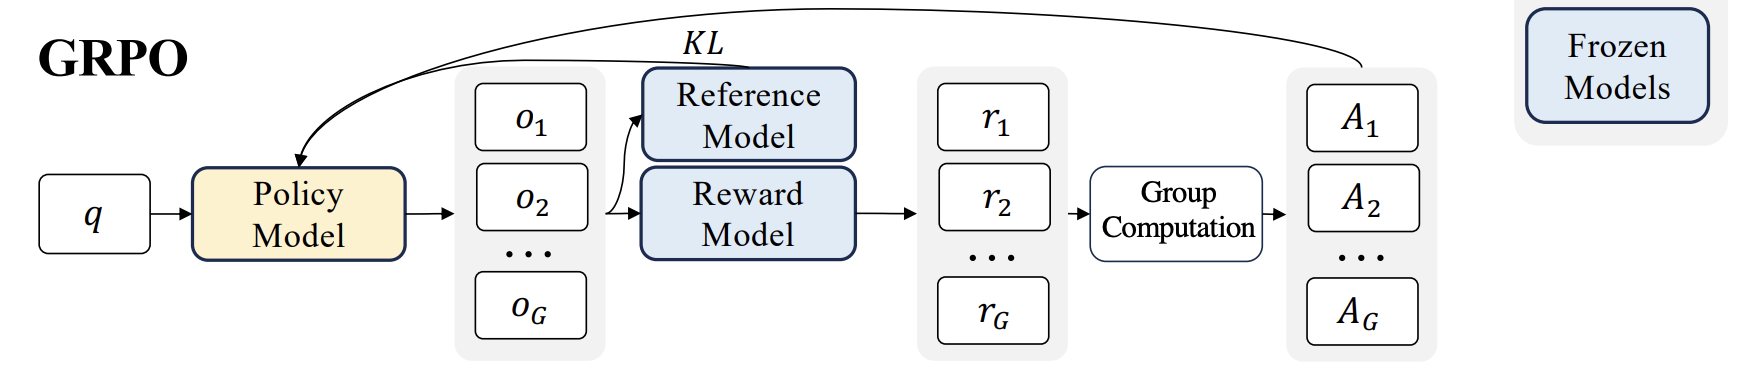
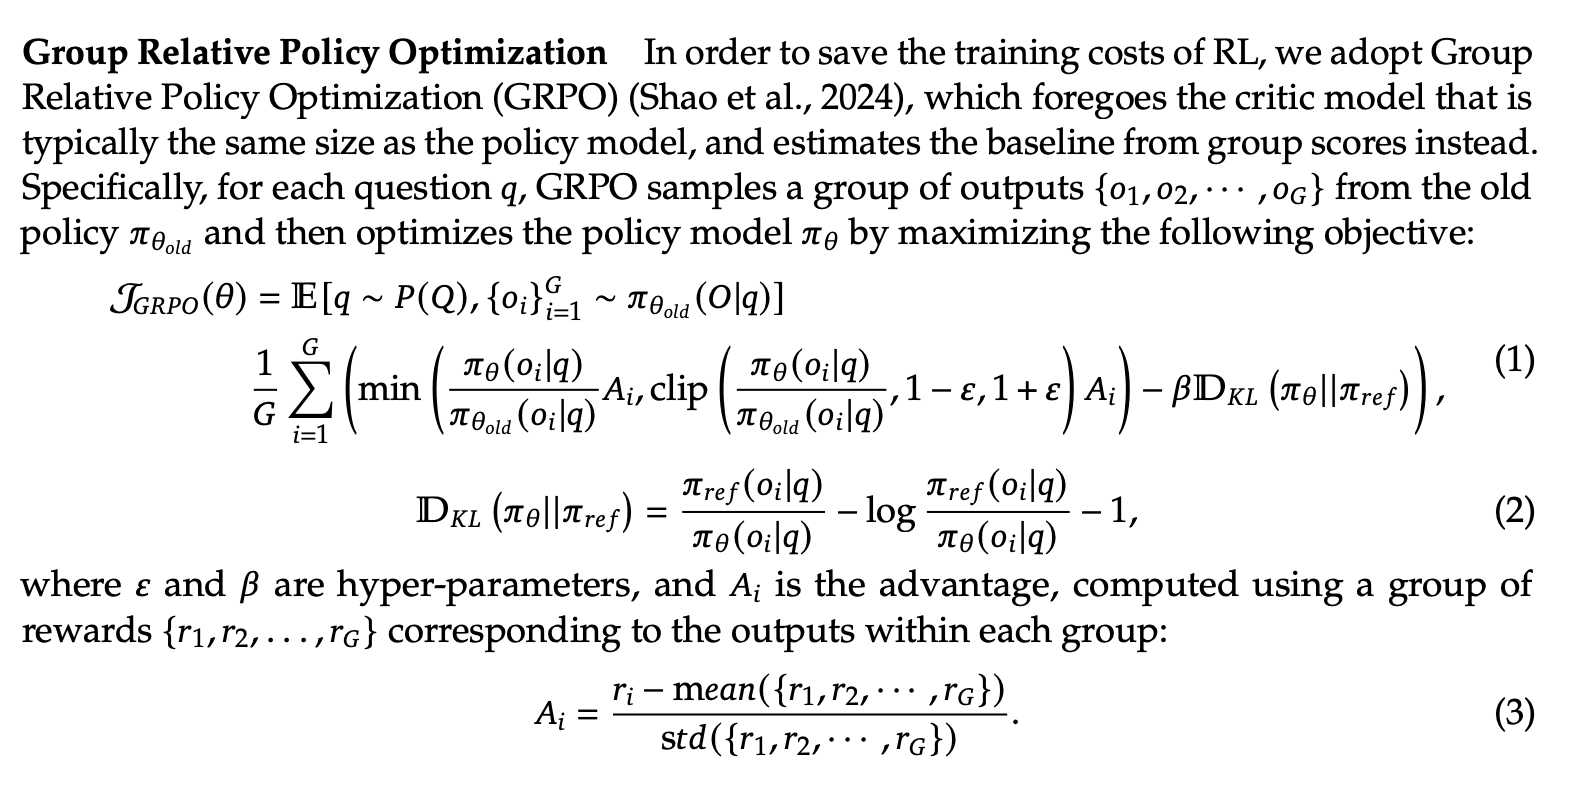

### Sample from ref instruct model

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-360M-Instruct" # also try HuggingFaceTB/SmolLM2-135M-Instruct
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

messages = [
    {"role": "system", "content": "Please respond in this specific format ONLY:\n<thinking>\n input your reasoning behind your answer in between these reasoning tags.\n</thinking>\n<answer>\nyour answer in between these answer tags.\n</answer>\n"},
    {"role": "user", "content": "Which is heavier 1kg of steel or 1kg of wool?\n"},
]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=100, temperature=0.2, top_p=0.9, do_sample=True, use_cache=False)
print(tokenizer.decode(outputs[0]))

<|im_start|>system
Please respond in this specific format ONLY:
<thinking>
 input your reasoning behind your answer in between these reasoning tags.
</thinking>
<answer>
your answer in between these answer tags.
</answer>
<|im_end|>
<|im_start|>user
Which is heavier 1kg of steel or 1kg of wool?
<|im_end|>
<|im_start|>assistant
<thinking>
1kg of steel is heavier than 1kg of wool. Steel is a denser material, meaning it has a higher mass per unit volume. This is because steel is made from a combination of iron and carbon, which are both heavy elements. Wool, on the other hand, is made from a combination of protein fibers, which are lighter and less dense. Therefore, 1kg of steel is heavier than 1kg of wool.</thinking>



### Install libs

In [ ]:
!pip install datasets
!pip install vllm
!pip install flash-attn --no-build-isolation
!pip install trl

### Train

Streaming output truncated to the last 5000 lines.

Response:
<thinking>
Dakota's medical bill is the sum of the individual costs:
$900 for the bed
$250 for the specialists
$1800 for the ambulance ride
= $900 + $250 + $1800 = $3750
</thinking>
<answer>
Dakota's medical bill is $3750.

Extracted:
Dakota's medical bill is $3750.
================== End ==================

Step 77 | Loss: 0.0331 | Reward: 1.6021 | Reward Std: 0.3924 | Completion Length: 86.0000 | KL: 0.0000

=============== Completion 77 ===============
Question:
Itzayana is 4 inches taller than Zora, who is 8 inches shorter than Brixton. If Zara is 64 inches tall and has the same height as Brixton, calculate the average height of the four people.

Answer:
61

Response:
<thinking>
To find the average height of the four people, we need to first determine the height of each person. We know that Zora is 8 inches shorter than Brixton, and Zara is 64 inches tall. Since Zora is 8 inches shorter than Brixton, we can subtract 8 in

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Successfully pushed model and tokenizer to Jaward/smollm2_360m_grpo_gsm8k_reasoner


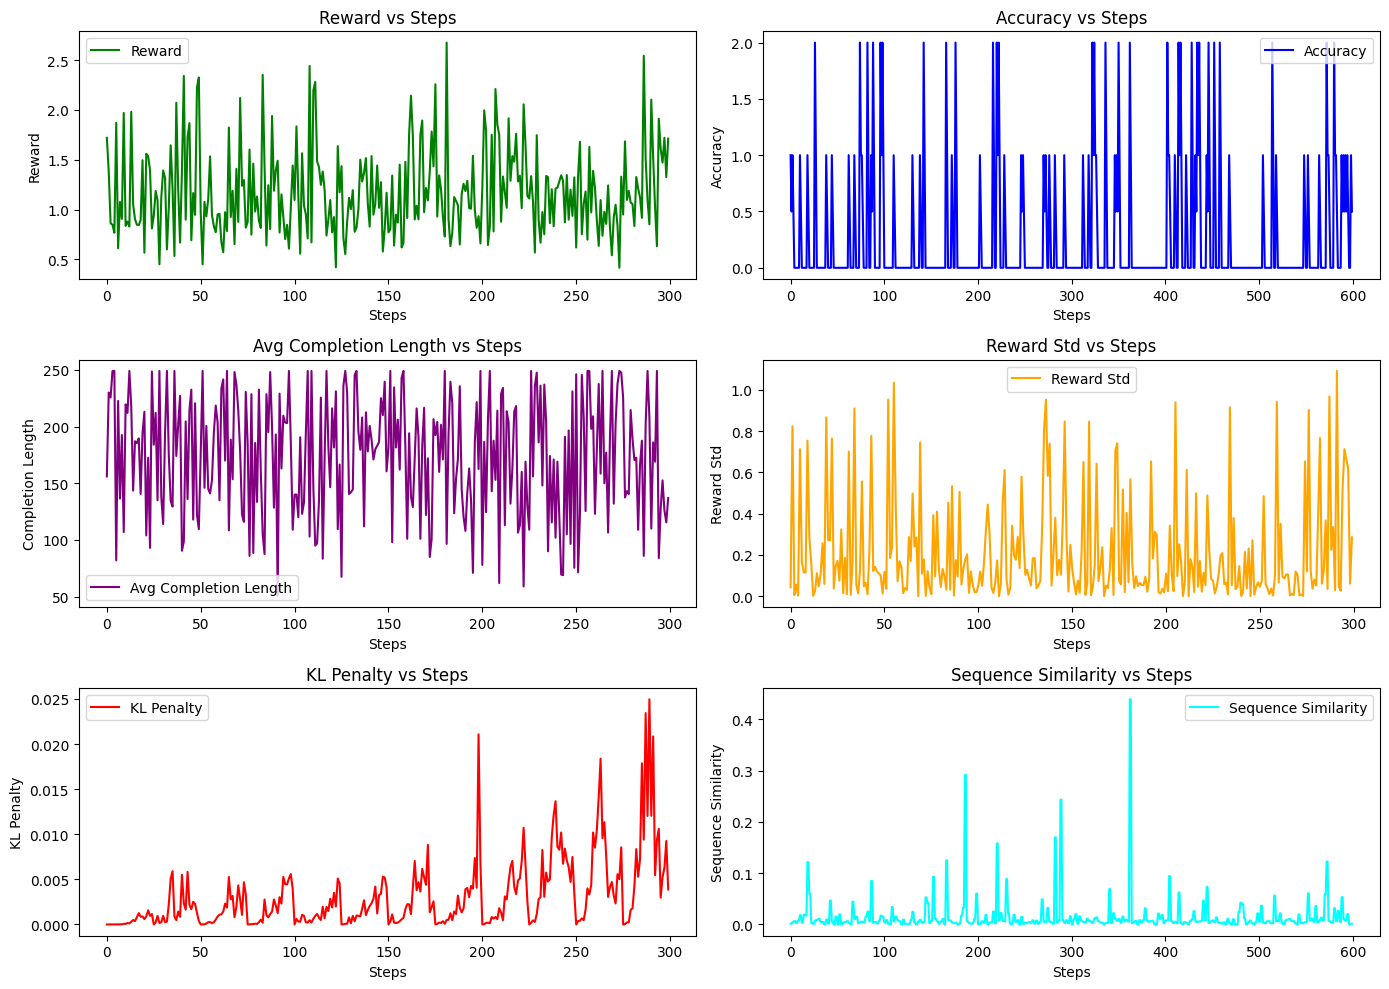

Question:
If there are 12 cookies in a dozen and you have 5 dozen, how many cookies do you have?

Final Model Response:
<thinking>
12 cookies in a dozen is 12/12 = 1
5 dozen is 5 * 12 = 60
So, you have 60 cookies.
</thinking>
<answer>
60


In [ ]:
import re
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, get_cosine_schedule_with_warmup
import warnings
from unittest.mock import patch
from huggingface_hub import HfApi
import numpy as np
import difflib

# -------------------------------
# Reasoning Prompt
# -------------------------------
SYSTEM_PROMPT = """
A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <thinking> </thinking><answer> answer here </answer>.
For example, always respond in this format:
<thinking>
Input our detailed chain-of-thought behind your answer goes here
</thinking>
<answer>
Input your final answer goes here, keep it short (if the final answer is number, only input the number here, no further explanation needed)
</answer>
"""

# -------------------------------
# Helper Functions
# -------------------------------
def get_user_prompt(prompt: str) -> str:
    match = re.search(r"<\|im_start\|>user\s*(.*?)\s*<\|im_end\|>", prompt, re.DOTALL)
    if match:
        return match.group(1).strip()
    lines = prompt.splitlines()
    result = []
    for line in lines:
        if not line.strip().lower().startswith("system"):
            if line.strip().lower().startswith("user"):
                result.append(line.strip()[4:].strip())
            else:
                result.append(line)
    return "\n".join(result).strip()

def get_assistant_response(text: str) -> str:
    match = re.search(r"<\|im_start\|>assistant\s*(.*?)\s*<\|im_end\|>", text, re.DOTALL)
    if match:
        return match.group(1).strip()
    lines = text.splitlines()
    result = []
    capture = False
    for line in lines:
        stripped = line.strip()
        if stripped.lower().startswith("assistant"):
            capture = True
            continue
        if capture:
            result.append(line)
    return "\n".join(result).strip()

def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str:
    if "####" not in text:
        return text.strip()
    return text.split("####", 1)[1].strip()

def count_xml(text: str) -> float:
    count = 0.0
    if text.count("<thinking>\n") >= 1:
        count += 0.625
    if text.count("\n</thinking>\n") >= 1:
        count += 0.625
    if text.count("\n<answer>\n") >= 1:
        count += 0.625
        count -= len(text.split("\n</answer>")[-1]) * 0.001
    if text.count("\n</answer>\n") >= 1:
        count += 0.625
        count -= (len(text.split("\n</answer>")[-1]) - 1) * 0.001
    return count

def inference_hf(prompt: str, model_path, config) -> list[str]:
    device = config.device
    model_infer = AutoModelForCausalLM.from_pretrained(model_path).to(device)
    tokenizer_infer = AutoTokenizer.from_pretrained(model_path)
    inputs = tokenizer_infer(prompt, return_tensors="pt", max_length=config.max_prompt_length, truncation=False)
    outputs = model_infer.generate(
        inputs["input_ids"].to(device),
        attention_mask=inputs["attention_mask"].to(device),
        max_new_tokens=config.max_completion_length,
        do_sample=True,
        pad_token_id=tokenizer_infer.eos_token_id,
        temperature=config.temperature,
        num_return_sequences=1,
        use_cache=False
    )
    full_text = tokenizer_infer.decode(outputs[0])
    user_question = get_user_prompt(prompt)
    assistant_response = get_assistant_response(full_text)
    extracted_answer = extract_xml_answer(assistant_response)
    return f"{'='*10} Inference {'='*10}\nQuestion:\n{user_question}\n\nModel Response:\n{assistant_response}\n\nExtracted:\n{extracted_answer}\n{'='*12} End {'='*12}\n"

# -------------------------------
# Reward Functions
# -------------------------------
def accuracy_reward(prompts, completions, answer, *args, num_generated_samples_to_view=None, q_num=None, step_num=None, **kwargs) -> list:
    q = prompts[0]
    user_question = get_user_prompt(q)
    assistant_responses = [get_assistant_response(r) for r in completions]
    extracted_responses = [extract_xml_answer(get_assistant_response(r)) for r in completions]
    if step_num is not None and step_num < num_generated_samples_to_view: # Check step_num against num_generated_samples_to_view
        completion_num_str = f"Completion {q_num}" if q_num is not None else "Completion" # Use q_num if available, otherwise generic "Completion"
        print(f"{'='*15} {completion_num_str} {'='*15}\nQuestion:\n{user_question}\n\nAnswer:\n{answer[0]}\n\nResponse:\n{assistant_responses[0]}\n\nExtracted:\n{extracted_responses[0]}\n{'='*18} End {'='*18}\n")

    rewards = []
    for r, a in zip(extracted_responses, answer):
        gt_number_match = False
        extracted_number_match = False

        gt_answer_number_str = extract_hash_answer(a)
        if gt_answer_number_str.isdigit():
            gt_number = int(gt_answer_number_str)
            response_numbers = re.findall(r'\d+', r)
            for response_num_str in response_numbers:
                if response_num_str.isdigit():
                    response_num = int(response_num_str)
                    if response_num == gt_number:
                        extracted_number_match = True
                        break
            if extracted_number_match:
                gt_number_match = True


        if gt_number_match:
            rewards.append(1.0) # give half the reward if numeric answer is in response tho not given in the required format
        elif r.strip() == a.strip():
            rewards.append(2.0) # give full reward
        else:
            rewards.append(0.0)
    return rewards

def soft_format_reward(prompts, completions, answer, *args, **kwargs) -> list:
    pattern = r"<thinking>.*?</thinking>\s*<answer>.*?</answer>"
    return [0.5 if re.search(pattern, comp, re.DOTALL) else 0.0 for comp in completions]

def strict_format_reward(prompts, completions, answer, *args, **kwargs) -> list:
    pattern = r"^<thinking>\n.*?\n</thinking>\n<answer>\n.*?\n</answer>$"
    return [1.0 if re.fullmatch(pattern, comp) else 0.0 for comp in completions]

def xmlcount_reward(prompts, completions, answer, *args, **kwargs) -> list:
    return [count_xml(comp) * 0.5 for comp in completions]

def int_reward(prompts, completions, answer, *args, **kwargs) -> list:
    return [0.5 if get_assistant_response(comp).strip().isdigit() else 0.0 for comp in completions]

def reasoning_reward(prompts, completions, answer, *args, **kwargs) -> list:
    rewards = []
    transition_words = ["first", "next", "then", "because", "wait", "aha", "therefore", "finally", "in summary"]
    pattern = r"<\s*thinking\s*>(.*?)<\s*/\s*thinking\s*>"
    for comp in completions:
        match = re.search(pattern, comp, re.DOTALL | re.IGNORECASE)
        if match:
            reasoning_text = match.group(1).strip()
            words = reasoning_text.split()
            reward = 0.0
            if len(words) >= 25:
                reward += 0.25
            lower_text = reasoning_text.lower()
            transition_count = sum(1 for word in transition_words if word in lower_text)
            if transition_count > 0:
                reward += 0.5
            if len(words) >= 50:
                reward += 0.35
            rewards.append(reward)
        else:
            rewards.append(0.0)
    return rewards

def sequence_similarity_reward(prompts, completions, answer, *args, **kwargs) -> list:
    extracted_responses = [extract_xml_answer(get_assistant_response(r)) for r in completions]
    rewards = []
    for pred_patch, gt_patch in zip(extracted_responses, [answer] * len(completions)):
        if not pred_patch:
            rewards.append(-1.0)
        else:
            matcher = difflib.SequenceMatcher(None, pred_patch, gt_patch[0])
            similarity = matcher.ratio()
            rewards.append(similarity)
    return rewards

# -------------------------------
# Custom GRPO Configuration
# -------------------------------
class GRPOConfig:
    def __init__(self, **kwargs):
        self.output_dir = kwargs.get("output_dir", "outputs")
        self.run_name = kwargs.get("run_name", "custom_grpo")
        self.learning_rate = kwargs.get("learning_rate", 3e-6)
        self.weight_decay = kwargs.get("weight_decay", 0.01)
        self.warmup_steps = kwargs.get("warmup_steps", 25)
        self.num_generations = kwargs.get("num_generations", 2)
        self.max_prompt_length = kwargs.get("max_prompt_length", 512)
        self.max_completion_length = kwargs.get("max_completion_length", 200)
        self.num_train_epochs = kwargs.get("num_train_epochs", 1)
        self.gradient_accumulation_steps = kwargs.get("gradient_accumulation_steps", 2)
        self.clip_epsilon = kwargs.get("clip_epsilon", 0.15)
        self.beta = kwargs.get("beta", 0.01)
        self.logging_steps = kwargs.get("logging_steps", 1)
        self.save_steps = kwargs.get("save_steps", 5)
        self.max_steps = kwargs.get("max_steps", 100)
        self.device = kwargs.get("device", "cuda" if torch.cuda.is_available() else "cpu")
        self.temperature = kwargs.get("temperature", 0.3)
        self.num_generated_samples_to_view = kwargs.get("num_generated_samples_to_view", 50)
        self.bf16 = kwargs.get("bf16", True)
        self.per_device_train_batch_size = kwargs.get("per_device_train_batch_size", 1)
        self.use_flash_attn_2 = kwargs.get("use_flash_attn_2", False)
        self.use_vllm = kwargs.get("use_vllm", False)
        self.vllm_device = kwargs.get("vllm_device", "auto")
        self.vllm_gpu_memory_utilization = kwargs.get("vllm_gpu_memory_utilization", 0.3)
        self.vllm_dtype = kwargs.get("vllm_dtype", "bfloat16" if kwargs.get("bf16", True) else "float16")
        self.vllm_max_model_len = kwargs.get("vllm_max_model_len", 512)
        self.vllm_enforce_eager = kwargs.get("vllm_enforce_eager", False)
        self.push_to_hub = kwargs.get("push_to_hub", False)
        self.hub_repo_id = kwargs.get("hub_repo_id", None)
        self.hub_token = kwargs.get("hub_token", None)
        self.sync_ref_model = True
        self.max_grad_norm = kwargs.get("max_grad_norm", 0.5)


# -------------------------------
# Custom GRPO Trainer with vLLM Support
# -------------------------------
class GRPOTrainer:
    def __init__(self, model, tokenizer, reward_funcs, config, train_dataset):
        self.dataloader = DataLoader(train_dataset, batch_size=config.per_device_train_batch_size, shuffle=True, collate_fn=lambda x: x)
        self.model = model.to(config.device)
        self.tokenizer = tokenizer
        self.reward_funcs = reward_funcs
        self.config = config
        self.train_dataset = train_dataset

        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay,
            betas=(0.9, 0.999),
            eps=1e-8
        )

        total_steps = (len(train_dataset) // (config.per_device_train_batch_size * config.gradient_accumulation_steps)) * config.num_train_epochs
        self.scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=config.warmup_steps,
            num_training_steps=total_steps
        )

        # Initialize reference model
        self.ref_model = AutoModelForCausalLM.from_pretrained(
            model.config.name_or_path if hasattr(model.config, 'name_or_path') else model.config._name_or_path
        ).to(config.device)
        self.ref_model.load_state_dict(model.state_dict())
        self.ref_model.eval()
        for param in self.ref_model.parameters():
            param.requires_grad = False

        self.step = 0
        self._metrics = defaultdict(list)
        self.scaler = torch.amp.GradScaler('cuda', enabled=(config.device.startswith("cuda") and not config.bf16)) if config.device.startswith("cuda") else None

        if self.config.use_vllm:
            from vllm import LLM, SamplingParams
            self.llm = self._initialize_vllm()
            self.sampling_params = SamplingParams(
                temperature=self.config.temperature,
                max_tokens=self.config.max_completion_length,
                n=self.config.num_generations,
                stop_token_ids=[self.tokenizer.eos_token_id]
            )
        else:
            self.llm = None

    def clear_memory_cache(self):
        if self.config.device.startswith("cuda"):
            with torch.no_grad():
                torch.cuda.empty_cache()

    def sync_ref_model(self):
        if self.step % 25 == 0 and self.step > 0:
            self.ref_model.load_state_dict(self.model.state_dict())
            print(f"Reference model synchronized at step {self.step}")

    def get_per_token_logps(self, model, full_ids, attention_mask, num_logits_to_keep):
        outputs = model(input_ids=full_ids, attention_mask=attention_mask)
        logits = outputs.logits[:, :-1, :]
        if num_logits_to_keep <= 0:
            return torch.empty(0, dtype=torch.float32, device=full_ids.device)
        logits_slice = logits[:, -num_logits_to_keep:, :]
        token_ids = full_ids[:, -num_logits_to_keep:]

        log_probs = torch.log_softmax(logits_slice, dim=-1)
        token_log_probs = log_probs.gather(dim=-1, index=token_ids.unsqueeze(-1)).squeeze(-1)
        return token_log_probs

    def compute_loss(self, input_ids, generation_output, advantages, old_logps, attention_mask):
        num_logits_to_keep = generation_output.shape[1] - input_ids.shape[1]
        full_ids = generation_output

        if num_logits_to_keep <= 0:
            return torch.tensor(0.0, device=input_ids.device), 0.0, 0.0

        per_token_logps = self.get_per_token_logps(self.model, full_ids, attention_mask, num_logits_to_keep)

        with torch.no_grad():
            ref_per_token_logps = self.get_per_token_logps(self.ref_model, full_ids, attention_mask, num_logits_to_keep)

        logp_diff = ref_per_token_logps - per_token_logps
        logp_diff = torch.clamp(logp_diff, -10.0, 10.0)
        per_token_kl = torch.exp(logp_diff) - logp_diff - 1
        per_token_kl = torch.clamp(per_token_kl, 0.0, 5.0)

        completion_ids = full_ids[:, input_ids.shape[1]:]
        is_eos = (completion_ids == self.tokenizer.eos_token_id)
        batch_size, seq_len = is_eos.size()
        device = input_ids.device
        eos_idx = torch.full((batch_size,), seq_len, dtype=torch.long, device=device)
        for i in range(batch_size):
            nonzero = torch.nonzero(is_eos[i], as_tuple=False)
            if nonzero.numel() > 0:
                eos_idx[i] = nonzero[0, 0]
        sequence_indices = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        mask = (sequence_indices <= eos_idx.unsqueeze(1)).float()

        ratio = torch.exp(per_token_logps - old_logps)
        ratio = torch.clamp(ratio, 0.1, 10.0)
        clipped_ratio = torch.clamp(ratio, 1 - self.config.clip_epsilon, 1 + self.config.clip_epsilon)

        surrogate1 = ratio * advantages.unsqueeze(1)
        surrogate2 = clipped_ratio * advantages.unsqueeze(1)
        surrogate_loss = -torch.min(surrogate1, surrogate2)

        beta = self.config.beta
        if per_token_kl.mean() > 1.0:
            beta = self.config.beta * 2.0

        per_token_loss = surrogate_loss + beta * per_token_kl

        valid_mask = mask * (torch.isfinite(per_token_loss))
        valid_tokens = valid_mask.sum() + 1e-8
        loss = (per_token_loss * valid_mask).sum() / valid_tokens

        if not torch.isfinite(loss):
            print("Warning: Non-finite loss detected, using fallback loss")
            loss = torch.tensor(0.01, device=loss.device)

        mean_kl = (per_token_kl * valid_mask).sum() / valid_tokens
        mean_kl = mean_kl.item()

        completion_length = mask.sum(dim=1).mean().item()
        return loss, mean_kl, completion_length

    def evaluate_rewards(self, prompt, completions, gt_answer):
        rewards_dict = {}
        combined_rewards = []
        for i, comp in enumerate(completions):
            sample_rewards = []
            for func in self.reward_funcs:
                r = func([prompt], [comp], [gt_answer], **self.config.__dict__)
                sample_rewards.append(r[0])
                rewards_dict.setdefault(func.__name__, []).append(r[0])
            combined_reward = sum(sample_rewards)
            combined_rewards.append(combined_reward)

        # for k, v in rewards_dict.items():
        #     print(f"{k}: {v}")

        return combined_rewards, rewards_dict


    def _initialize_vllm(self):
        try:
            from vllm import LLM, SamplingParams
        except ImportError:
            raise ImportError("vLLM is not available. Please install vLLM with `pip install vllm`.")

        vllm_device = self.config.vllm_device
        if vllm_device == "auto":
            if torch.cuda.device_count() == 1:
                vllm_device = "cuda:0"
            else:
                vllm_device = f"cuda:{self.config.device}"

        if vllm_device.split(":")[0] == "cuda" and int(vllm_device.split(":")[1]) >= torch.cuda.device_count():
            raise ValueError(f"The requested device for vllm ({vllm_device}) is not available.")

        world_size_patch = patch("torch.distributed.get_world_size", return_value=1)
        profiling_patch = patch("vllm.worker.worker.Worker._assert_memory_footprint_increased_during_profiling", return_value=None)

        with world_size_patch, profiling_patch:
            llm_instance = LLM(
                model=self.model.config._name_or_path,
                device=vllm_device,
                gpu_memory_utilization=self.config.vllm_gpu_memory_utilization,
                dtype=self.config.vllm_dtype,
                max_model_len=self.config.vllm_max_model_len,
                enable_prefix_caching=True,
            )
        self.sampling_params = SamplingParams(
            temperature=self.config.temperature,
            max_tokens=self.config.max_completion_length,
            n=self.config.num_generations,
            stop_token_ids=[self.tokenizer.eos_token_id]
        )
        self._last_loaded_step = 0
        return llm_instance


    def train(self):
        self.model.train()
        accumulation_counter = 0
        for epoch in range(self.config.num_train_epochs):
            for batch_idx, batch in enumerate(self.dataloader):
                if self.step >= self.config.max_steps:
                    break

                self.clear_memory_cache()
                example = batch[0]
                prompts = example["prompts"]
                gt_answer = example["answer"]
                prompt_text = self.tokenizer.apply_chat_template(prompts, tokenize=False)
                inputs = self.tokenizer(prompt_text, return_tensors="pt", max_length=self.config.max_prompt_length, truncation=False)
                input_ids = inputs.input_ids.to(self.config.device)
                attention_mask = inputs.attention_mask.to(self.config.device)

                with torch.autocast(
                    device_type=self.config.device,
                    enabled=(self.scaler is not None),
                    dtype=(torch.bfloat16 if self.config.bf16 else torch.float16)
                ):
                    if self.config.use_vllm:
                        vllm_prompts = [prompt_text] * self.config.num_generations
                        vllm_outputs = self.llm.generate(vllm_prompts, sampling_params=self.sampling_params, use_tqdm=False)
                        completions = [output.outputs[0].text for output in vllm_outputs]

                        generation_output_ids = []
                        for completion_text in completions:
                            full_text = prompt_text + completion_text
                            tokenized_output = self.tokenizer.encode(full_text, return_tensors="pt", add_special_tokens=False)
                            gen_ids = tokenized_output[:, input_ids.shape[1]:].to(self.config.device)
                            if gen_ids.numel() == 0:
                                print(f"Warning: vLLM generated no new tokens for batch_idx {batch_idx}, step {self.step}. Completion was likely stopped early.")
                                continue
                            generation_output_ids.append(gen_ids)

                        if not generation_output_ids:
                            print(f"Warning: No valid generation outputs after processing vLLM outputs for batch_idx {batch_idx}, step {self.step}. Skipping step.")
                            continue
                        else:
                            max_gen_len = max(gen_ids.shape[1] for gen_ids in generation_output_ids)
                            padded_generation_output_ids = [
                                F.pad(gen_ids, (0, max_gen_len - gen_ids.shape[1]), 'constant', self.tokenizer.pad_token_id)
                                for gen_ids in generation_output_ids
                            ]
                            generation_output_ids = torch.cat(padded_generation_output_ids, dim=0)
                            generation_output = torch.cat([input_ids.repeat(self.config.num_generations, 1), generation_output_ids], dim=1)


                    else:
                        generation_output = self.model.generate(
                            input_ids,
                            attention_mask=attention_mask,
                            max_new_tokens=self.config.max_completion_length,
                            do_sample=True,
                            temperature=self.config.temperature,
                            num_return_sequences=self.config.num_generations,
                            pad_token_id=self.tokenizer.eos_token_id,
                            use_cache=False
                        ).to(self.config.device)

                    generation_output = generation_output.to(self.config.device)
                    completions = [self.tokenizer.decode(seq, skip_special_tokens=True) for seq in generation_output]
                    completions = [c.replace(prompt_text, "").strip() if prompt_text in c else c for c in completions]

                    num_gens = len(completions)
                    view_flag = (self.step < self.config.num_generated_samples_to_view)
                    acc_rewards = accuracy_reward([prompt_text]*num_gens, completions, [gt_answer]*num_gens,
                                                  num_generated_samples_to_view=self.config.num_generated_samples_to_view, q_num=self.step, step_num=self.step) # Pass step_num here
                    seq_sim_rewards = sequence_similarity_reward([prompt_text]*num_gens, completions, [gt_answer]*num_gens)
                    combined_rewards, reward_dict = self.evaluate_rewards(prompt_text, completions, gt_answer)

                    rewards_tensor = torch.tensor(combined_rewards, device=self.config.device, dtype=torch.float)

                    reward_avg = rewards_tensor.mean().item()
                    reward_std = rewards_tensor.std().item() if rewards_tensor.numel() > 1 else 0.0

                    if self.config.num_generations > 1:
                        if rewards_tensor.numel() < self.config.num_generations:
                            advantages = rewards_tensor
                        else:
                            rewards_grouped = rewards_tensor.view(-1, self.config.num_generations)
                            mean_rewards = rewards_grouped.mean(dim=1)
                            std_rewards = rewards_grouped.std(dim=1) + 1e-8
                            advantages = (rewards_tensor - mean_rewards.repeat_interleave(self.config.num_generations)) / std_rewards.repeat_interleave(self.config.num_generations)
                    else:
                        advantages = rewards_tensor
                    advantages = torch.clamp(advantages, -5.0, 5.0)

                    num_logits_to_keep = generation_output.shape[1] - input_ids.shape[1]
                    expanded_attention_mask = attention_mask.repeat(self.config.num_generations, 1)
                    with torch.no_grad():
                        old_logps = self.get_per_token_logps(self.ref_model, generation_output[:, :input_ids.shape[1] + max(0, num_logits_to_keep)], expanded_attention_mask, max(0, num_logits_to_keep)).detach()

                    loss, mean_kl, completion_length = self.compute_loss(input_ids.repeat(self.config.num_generations, 1), generation_output[:, :input_ids.shape[1] + max(0, num_logits_to_keep)], advantages, old_logps, expanded_attention_mask)

                    loss = loss / self.config.gradient_accumulation_steps
                    if self.scaler is not None:
                        self.scaler.scale(loss).backward()
                    else:
                        loss.backward()
                    accumulation_counter += 1
                    if accumulation_counter % self.config.gradient_accumulation_steps == 0:
                        self.clear_memory_cache()
                        if self.scaler is not None:
                            self.scaler.unscale_(self.optimizer)
                            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                            self.scaler.step(self.optimizer)
                            self.scaler.update()
                        else:
                            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                            self.optimizer.step()
                        self.scheduler.step()
                        self.optimizer.zero_grad()
                        accumulation_counter = 0

                        self.step += 1
                        self.sync_ref_model()

                        self._metrics["loss"].append(loss.item() * self.config.gradient_accumulation_steps)
                        self._metrics["completion_length"].append(completion_length)
                        self._metrics["reward"].append(reward_avg)
                        self._metrics["reward_std"].append(reward_std)
                        self._metrics["accuracy_reward"].append(sum(acc_rewards))
                        self._metrics["sequence_similarity_reward"].append(sum(seq_sim_rewards) / len(seq_sim_rewards) if seq_sim_rewards else 0)
                        for func_name in reward_dict:
                            self._metrics[func_name] .append(sum(reward_dict[func_name]) / len(reward_dict[func_name]) if reward_dict[func_name] else 0)
                        self._metrics["kl"].append(mean_kl)
                        print(f"Step {self.step} | Loss: {loss.item()*self.config.gradient_accumulation_steps:.4f} | "
                            f"Reward: {reward_avg:.4f} | Reward Std: {reward_std:.4f} | "
                            f"Completion Length: {completion_length:.4f} | KL: {mean_kl:.4f}\n")

                if self.step >= self.config.max_steps:
                    break
            if self.step >= self.config.max_steps:
                break

        final_model_path = os.path.join(self.config.output_dir, "final_model")
        os.makedirs(final_model_path, exist_ok=True)
        self.model.save_pretrained(final_model_path)
        self.tokenizer.save_pretrained(final_model_path)
        print(f"Final model saved to {final_model_path}")

        if self.config.push_to_hub:
            if self.config.hub_repo_id is None:
                raise ValueError("`hub_repo_id` must be set in GRPOConfig to push to Hugging Face Hub.")
            print(f"Pushing model to hub: {self.config.hub_repo_id}")
            try:
                self.model.push_to_hub(self.config.hub_repo_id, token=self.config.hub_token)
                self.tokenizer.push_to_hub(self.config.hub_repo_id, token=self.config.hub_token)
                print(f"Successfully pushed model and tokenizer to {self.config.hub_repo_id}")
            except Exception as e:
                print(f"Error pushing to Hugging Face Hub: {e}")


        plt.figure(figsize=(14, 10))

        plt.subplot(3, 2, 1)
        plt.plot(self._metrics["reward"], label="Reward", color="green")
        plt.title("Reward vs Steps")
        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.legend()

        plt.subplot(3, 2, 2)
        plt.plot(self._metrics["accuracy_reward"], label="Accuracy", color="blue")
        plt.title("Accuracy vs Steps")
        plt.xlabel("Steps")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(3, 2, 3)
        plt.plot(self._metrics["completion_length"], label="Avg Completion Length", color="purple")
        plt.title("Avg Completion Length vs Steps")
        plt.xlabel("Steps")
        plt.ylabel("Completion Length")
        plt.legend()

        plt.subplot(3, 2, 4)
        plt.plot(self._metrics["reward_std"], label="Reward Std", color="orange")
        plt.title("Reward Std vs Steps")
        plt.xlabel("Steps")
        plt.ylabel("Reward Std")
        plt.legend()

        plt.subplot(3, 2, 5)
        plt.plot(self._metrics["kl"], label="KL Penalty", color="red")
        plt.title("KL Penalty vs Steps")
        plt.xlabel("Steps")
        plt.ylabel("KL Penalty")
        plt.legend()

        plt.subplot(3, 2, 6)
        plt.plot(self._metrics["sequence_similarity_reward"], label="Sequence Similarity", color="cyan")
        plt.title("Sequence Similarity vs Steps")
        plt.xlabel("Steps")
        plt.ylabel("Sequence Similarity")
        plt.legend()

        plt.tight_layout()
        plt.show()

# -------------------------------
# Get GSM8K & Prep Chat template
# -------------------------------
def get_gsm8k_data(split="train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split]
    data = data.map(lambda x: {
        'prompts': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    })
    return data

dataset = get_gsm8k_data()

# -------------------------------
# Init Trainer and Config
# -------------------------------
config = GRPOConfig(
    output_dir="/content/drive/MyDrive/outputs/smollm2_360m_grpo_gsm8k",
    run_name="smollm2_360m_grpo_gsm8k_reasoner",
    learning_rate=5e-6,
    weight_decay=0.01,
    warmup_steps=10,
    num_generations=2,
    max_prompt_length=512,
    max_completion_length=250,
    num_train_epochs=1,
    gradient_accumulation_steps=2,
    clip_epsilon=0.2,
    beta=0.02,
    logging_steps=1,
    save_steps=300,
    max_steps=300,
    num_generated_samples_to_view=150,
    temperature=0.2,
    bf16=False,
    per_device_train_batch_size=1,
    use_flash_attn_2=False,
    use_vllm=True,
    vllm_device="auto",
    vllm_gpu_memory_utilization=0.1,
    push_to_hub=False,
    # hub_repo_id="yOUR_HF_REPO_ID",
    # hub_token="YOUR_HF_TOKEN_ID",
)

model_name = "HuggingFaceTB/SmolLM2-360M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    attn_implementation="flash_attention_2" if config.use_flash_attn_2 else None,
    use_cache=False,
    torch_dtype=torch.bfloat16 if config.bf16 else torch.float32
).to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer.pad_token = tokenizer.eos_token

reward_functions = [reasoning_reward, accuracy_reward, soft_format_reward, strict_format_reward, int_reward, xmlcount_reward, sequence_similarity_reward]
config.reward_funcs = reward_functions
trainer = GRPOTrainer(model, tokenizer, reward_functions, config, dataset)

# -------------------------------
# Train
# -------------------------------
trainer.train()

# -------------------------------
# Sample from final model
# -------------------------------
sample = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": "If there are 12 cookies in a dozen and you have 5 dozen, how many cookies do you have?"}
]
final_prompt = tokenizer.apply_chat_template(sample, tokenize=False)
if config.use_vllm:
    vllm_final_output = trainer.llm.generate(final_prompt, sampling_params=trainer.sampling_params, use_tqdm=False)
    final_inference_result = [output.outputs[0].text for output in vllm_final_output]
    user_question = get_user_prompt(final_prompt)
    assistant_response = get_assistant_response(final_inference_result[0])
    print(f"Question:\n{user_question}\n")
    print(f"Final Model Response:\n{assistant_response}")
else:
    print(inference_hf(final_prompt, os.path.join(config.output_dir, "final_model"), config))